# Bayesian Personalized Ranking (BPR)

## 0 Global Settings and Imports

In [1]:
import sys
import os
import cornac
import pandas as pd
from recommenders.datasets.python_splitters import python_random_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.models.cornac.cornac_utils import predict_ranking
from recommenders.utils.timer import Timer
from recommenders.utils.constants import SEED

print("System version: {}".format(sys.version))
print("Cornac version: {}".format(cornac.__version__))

/Users/DanielShen/opt/anaconda3/envs/microsoft_rec/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FM model is only supported on Linux.
Windows executable can be found at http://www.libfm.org.
System version: 3.8.17 (default, Jul  5 2023, 16:18:40) 
[Clang 14.0.6 ]
Cornac version: 1.15.4


In [2]:
DATA_FILE_NAME = "../Data/20230721T235400_sales_24mo_basic_single_events_removed.csv"
THIS_ENGINE_NAME = "bpr_field_1"

# country
COUNTRY = "nigeria"

# top k items to recommend, for train & test
TOP_K_SPLIT_TRAIN_TEST = 10
# top k items to recommend, for final product recommendation output
TOP_K_WHOLE = 100

# fraction of location_skus to include in training dataset
TRAIN_FRAC = 0.75

# Model parameters
NUM_FACTORS = 200
NUM_EPOCHS = 100
LEARNING_RATE = 0.01
LAMBDA_REG = 0.001

## 1 Data


### 1.1 Load and split data

To evaluate the performance of item recommendation, we adopted the provided `python_random_split` tool for the consistency.  Data is randomly split into training and test sets with the ratio of 75/25.


Note that Cornac also cover different [built-in schemes](https://cornac.readthedocs.io/en/latest/eval_methods.html) for model evaluation.

In [3]:
data_all_cols = pd.read_csv(DATA_FILE_NAME)
data_all_cols = data_all_cols[data_all_cols["country"] == COUNTRY]

data = data_all_cols[["location_id", "product", "sl_sold"]]

data.head()

,location_id,product,sl_sold
193,"""004c6ec1-9722-4ede-a152-85d48a8fb2ae""",Emzor Paracetamol 500mg Tablets x96,53.0
194,"""004c6ec1-9722-4ede-a152-85d48a8fb2ae""",Brustan-N 100mg/5ml Suspension x100ml,5.0
195,"""004c6ec1-9722-4ede-a152-85d48a8fb2ae""",Syrup Paracetamol 125mg/5ml (Emzor),11.0
196,"""004c6ec1-9722-4ede-a152-85d48a8fb2ae""",Em-Vit-C 100ml Syrup,8.0
197,"""004c6ec1-9722-4ede-a152-85d48a8fb2ae""",Funbact A 30g Cream,15.0


Here, we use quantity sold, not revenue of sales, for each product.

In [4]:
train, test = python_random_split(data, TRAIN_FRAC, seed = SEED)

### 1.2 Cornac Dataset

To work with models implemented in Cornac, we need to construct an object from [Dataset](https://cornac.readthedocs.io/en/latest/data.html#module-cornac.data.dataset) class.

Dataset Class in Cornac serves as the main object that the models will interact with.  In addition to data transformations, Dataset provides a bunch of useful iterators for looping through the data, as well as supporting different negative sampling techniques.

In [5]:
train_set = cornac.data.Dataset.from_uir(train.itertuples(index=False), seed=SEED)

print('Number of users: {}'.format(train_set.num_users))
print('Number of items: {}'.format(train_set.num_items))

Number of users: 967
Number of items: 2027


/Users/DanielShen/opt/anaconda3/envs/microsoft_rec/lib/python3.8/site-packages/cornac/data/dataset.py:361: UserWarning: 259 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


## 2 Training

The BPR has a few important parameters that we need to consider:

- `k`: controls the dimension of the latent space (i.e. the size of the vectors  $w_u$  and  $h_i$ ).
- `max_iter`: defines the number of iterations of the SGD procedure.
- `learning_rate`: controls the step size $\alpha$ in the gradient update rules.
- `lambda_reg`: controls the L2-Regularization $\lambda$ in the objective function.

Note that different values of `k` and `max_iter` will affect the training time.

We will here set `k` to 200, `max_iter` to 100, `learning_rate` to 0.01, and `lambda_reg` to 0.001. To train the model, we simply need to call the `fit()` method.

In [6]:
bpr = cornac.models.BPR(
    k=NUM_FACTORS,
    max_iter=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    lambda_reg=LAMBDA_REG,
    verbose=True,
    seed=SEED
)

In [7]:
with Timer() as t:
    bpr.fit(train_set)
print("Took {} seconds for training.".format(t))

100%|██████████| 100/100 [00:03<00:00, 32.04it/s, correct=94.84%, skipped=11.07%]

Optimization finished!
Took 3.1553 seconds for training.


## 3 Prediction

Now that our model is trained, we can produce the ranked lists for recommendation.  Every recommender models in Cornac provide `rate()` and `rank()` methods for predicting item rated value as well as item ranked list for a given user.  To make use of the current evaluation schemes, we will through `predict()` and `predict_ranking()` functions inside `cornac_utils` to produce the predictions.

Note that BPR model is effectively designed for item ranking.  Hence, we only measure the performance using ranking metrics.

In [8]:
with Timer() as t:
    all_predictions = predict_ranking(bpr, train, usercol='location_id', itemcol='product', remove_seen=True)
print("Took {} seconds for prediction.".format(t))

Took 1.2122 seconds for prediction.


In [9]:
all_predictions.head()

,location_id,product,prediction
143546,"""38b5a6fc-63ae-4a92-812f-7d97d1308d0a""",NCP Anteceptic Liquid 50ml,4.107578
143547,"""38b5a6fc-63ae-4a92-812f-7d97d1308d0a""",Loratadine (Afrab) 5mg/5ml Syrup x100ml,-0.264401
143548,"""38b5a6fc-63ae-4a92-812f-7d97d1308d0a""",Suitrox 250mg Tablets,1.950425
143549,"""38b5a6fc-63ae-4a92-812f-7d97d1308d0a""",Celebrex 200mg tablets x10,0.050516
143550,"""38b5a6fc-63ae-4a92-812f-7d97d1308d0a""",Emzor Paracetamol Drop 100mg/ml 15ml,-1.081264


## 4 Evaluation / Testing

In [10]:
eval_map = map_at_k(test, all_predictions, col_user='location_id', col_item='product', col_rating='sl_sold', col_prediction='prediction', k=TOP_K_SPLIT_TRAIN_TEST)
eval_ndcg = ndcg_at_k(test, all_predictions, col_user='location_id', col_item='product', col_rating='sl_sold', col_prediction='prediction', k=TOP_K_SPLIT_TRAIN_TEST)
eval_precision = precision_at_k(test, all_predictions, col_user='location_id', col_item='product', col_rating='sl_sold', col_prediction='prediction', k=TOP_K_SPLIT_TRAIN_TEST)
eval_recall = recall_at_k(test, all_predictions, col_user='location_id', col_item='product', col_rating='sl_sold', col_prediction='prediction', k=TOP_K_SPLIT_TRAIN_TEST)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.077656
NDCG:	0.509820
Precision@K:	0.493326
Recall@K:	0.111950


## 5 Additional exploration

### Revised/copied code from packages

In [11]:
import numpy as np


from recommenders.utils.constants import (
    DEFAULT_USER_COL,
    DEFAULT_ITEM_COL,
    DEFAULT_RATING_COL,
    DEFAULT_PREDICTION_COL,
    DEFAULT_RELEVANCE_COL,
    DEFAULT_SIMILARITY_COL,
    DEFAULT_ITEM_FEATURES_COL,
    DEFAULT_ITEM_SIM_MEASURE,
    DEFAULT_K,
    DEFAULT_THRESHOLD,
)


def _get_rating_column(relevancy_method: str, **kwargs) -> str:
    r"""Helper utility to simplify the arguments of eval metrics
    Attemtps to address https://github.com/microsoft/recommenders/issues/1737.

    Args:
        relevancy_method (str): method for determining relevancy ['top_k', 'by_threshold', None]. None means that the
            top k items are directly provided, so there is no need to compute the relevancy operation.

    Returns:
        str: rating column name.
    """
    if relevancy_method != "top_k":
        if "col_rating" not in kwargs:
            raise ValueError("Expected an argument `col_rating` but wasn't found.")
        col_rating = kwargs.get("col_rating")
    else:
        col_rating = kwargs.get("col_rating", DEFAULT_RATING_COL)
    return col_rating


def merge_ranking_true_pred(
    rating_true,
    rating_pred,
    col_user,
    col_item,
    col_rating,
    col_prediction,
    relevancy_method,
    k=DEFAULT_K,
    threshold=DEFAULT_THRESHOLD,
):
    """Filter truth and prediction data frames on common users

    Args:
        rating_true (pandas.DataFrame): True DataFrame
        rating_pred (pandas.DataFrame): Predicted DataFrame
        col_user (str): column name for user
        col_item (str): column name for item
        col_rating (str): column name for rating
        col_prediction (str): column name for prediction
        relevancy_method (str): method for determining relevancy ['top_k', 'by_threshold', None]. None means that the
            top k items are directly provided, so there is no need to compute the relevancy operation.
        k (int): number of top k items per user (optional)
        threshold (float): threshold of top items per user (optional)

    Returns:
        pandas.DataFrame, pandas.DataFrame, int: DataFrame of recommendation hits, sorted by `col_user` and `rank`
        DataFrame of hit counts vs actual relevant items per user number of unique user ids
    """

    # Make sure the prediction and true data frames have the same set of users
    common_users = set(rating_true[col_user]).intersection(set(rating_pred[col_user]))
    rating_true_common = rating_true[rating_true[col_user].isin(common_users)]
    rating_pred_common = rating_pred[rating_pred[col_user].isin(common_users)]
    n_users = len(common_users)

    # Return hit items in prediction data frame with ranking information. This is used for calculating NDCG and MAP.
    # Use first to generate unique ranking values for each item. This is to align with the implementation in
    # Spark evaluation metrics, where index of each recommended items (the indices are unique to items) is used
    # to calculate penalized precision of the ordered items.
    if relevancy_method == "top_k":
        top_k = k
    elif relevancy_method == "by_threshold":
        top_k = threshold
    elif relevancy_method is None:
        top_k = None
    else:
        raise NotImplementedError("Invalid relevancy_method")
    df_hit = get_top_k_items(
        dataframe=rating_pred_common,
        col_user=col_user,
        col_rating=col_prediction,
        k=top_k,
    )
    df_hit = pd.merge(df_hit, rating_true_common, on=[col_user, col_item])[
        [col_user, col_item, "rank"]
    ]

    # count the number of hits vs actual relevant items per user
    df_hit_count = pd.merge(
        df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
        rating_true_common.groupby(col_user, as_index=False)[col_user].agg(
            {"actual": "count"}
        ),
        on=col_user,
    )

    return df_hit, df_hit_count, n_users


def get_top_k_items(
    dataframe, col_user=DEFAULT_USER_COL, col_rating=DEFAULT_RATING_COL, k=DEFAULT_K
):
    """Get the input customer-item-rating tuple in the format of Pandas
    DataFrame, output a Pandas DataFrame in the dense format of top k items
    for each user.

    Note:
        If it is implicit rating, just append a column of constants to be
        ratings.

    Args:
        dataframe (pandas.DataFrame): DataFrame of rating data (in the format
        customerID-itemID-rating)
        col_user (str): column name for user
        col_rating (str): column name for rating
        k (int or None): number of items for each user; None means that the input has already been
        filtered out top k items and sorted by ratings and there is no need to do that again.

    Returns:
        pandas.DataFrame: DataFrame of top k items for each user, sorted by `col_user` and `rank`
    """
    # Sort dataframe by col_user and (top k) col_rating
    if k is None:
        top_k_items = dataframe
    else:
        top_k_items = (
            dataframe.sort_values([col_user, col_rating], ascending=[True, False])
            .groupby(col_user, as_index=False)
            .head(k)
            .reset_index(drop=True)
        )
    # Add ranks
    top_k_items["rank"] = top_k_items.groupby(col_user, sort=False).cumcount() + 1
    return top_k_items


def ndcg_at_k_hist(
    rating_true,
    rating_pred,
    col_user=DEFAULT_USER_COL,
    col_item=DEFAULT_ITEM_COL,
    col_prediction=DEFAULT_PREDICTION_COL,
    relevancy_method="top_k",
    k=DEFAULT_K,
    threshold=DEFAULT_THRESHOLD,
    score_type="binary",
    discfun_type="loge",
    **kwargs
):
    """Normalized Discounted Cumulative Gain (nDCG).

    Info: https://en.wikipedia.org/wiki/Discounted_cumulative_gain

    Args:
        rating_true (pandas.DataFrame): True DataFrame
        rating_pred (pandas.DataFrame): Predicted DataFrame
        col_user (str): column name for user
        col_item (str): column name for item
        col_rating (str): column name for rating
        col_prediction (str): column name for prediction
        relevancy_method (str): method for determining relevancy ['top_k', 'by_threshold', None]. None means that the
            top k items are directly provided, so there is no need to compute the relevancy operation.
        k (int): number of top k items per user
        threshold (float): threshold of top items per user (optional)
        score_type (str): type of relevance scores ['binary', 'raw', 'exp']. With the default option 'binary', the
            relevance score is reduced to either 1 (hit) or 0 (miss). Option 'raw' uses the raw relevance score.
            Option 'exp' uses (2 ** RAW_RELEVANCE - 1) as the relevance score
        discfun_type (str): type of discount function ['loge', 'log2'] used to calculate DCG.

    Returns:
        float: nDCG at k (min=0, max=1).
    """
    col_rating = _get_rating_column(relevancy_method, **kwargs)
    df_hit, _, _ = merge_ranking_true_pred(
        rating_true=rating_true,
        rating_pred=rating_pred,
        col_user=col_user,
        col_item=col_item,
        col_rating=col_rating,
        col_prediction=col_prediction,
        relevancy_method=relevancy_method,
        k=k,
        threshold=threshold,
    )

    if df_hit.shape[0] == 0:
        return 0.0

    df_dcg = df_hit.merge(rating_pred, on=[col_user, col_item]).merge(
        rating_true, on=[col_user, col_item], how="outer", suffixes=("_left", None)
    )

    if score_type == "binary":
        df_dcg["rel"] = 1
    elif score_type == "raw":
        df_dcg["rel"] = df_dcg[col_rating]
    elif score_type == "exp":
        df_dcg["rel"] = 2 ** df_dcg[col_rating] - 1
    else:
        raise ValueError("score_type must be one of 'binary', 'raw', 'exp'")

    if discfun_type == "loge":
        discfun = np.log
    elif discfun_type == "log2":
        discfun = np.log2
    else:
        raise ValueError("discfun_type must be one of 'loge', 'log2'")

    # Calculate the actual discounted gain for each record
    df_dcg["dcg"] = df_dcg["rel"] / discfun(1 + df_dcg["rank"])

    # Calculate the ideal discounted gain for each record
    df_idcg = df_dcg.sort_values([col_user, col_rating], ascending=False)
    df_idcg["irank"] = df_idcg.groupby(col_user, as_index=False, sort=False)[
        col_rating
    ].rank("first", ascending=False)
    df_idcg["idcg"] = df_idcg["rel"] / discfun(1 + df_idcg["irank"])

    # Calculate the actual DCG for each user
    df_user = df_dcg.groupby(col_user, as_index=False, sort=False).agg({"dcg": "sum"})

    # Calculate the ideal DCG for each user
    df_user = df_user.merge(
        df_idcg.groupby(col_user, as_index=False, sort=False)
        .head(k)
        .groupby(col_user, as_index=False, sort=False)
        .agg({"idcg": "sum"}),
        on=col_user,
    )

    # DCG over IDCG is the normalized DCG
    df_user["ndcg"] = df_user["dcg"] / df_user["idcg"]
    return df_user

### nDCG per location histogram

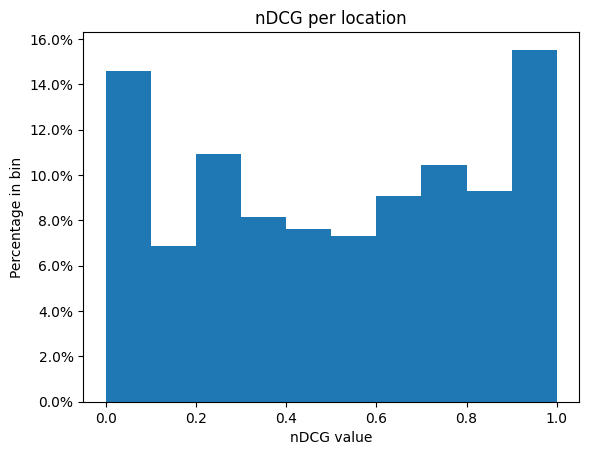

Average nDCG over all locations: 0.5110627618118884


In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

count_not_percentage = False
eval_with_ndcg_hist = ndcg_at_k_hist(test, all_predictions, col_user='location_id', col_item='product', col_rating='sl_sold', col_prediction='prediction', k=TOP_K_SPLIT_TRAIN_TEST)
eval_ndcg_hist = eval_with_ndcg_hist["ndcg"]

if count_not_percentage:
    plt.hist(eval_ndcg_hist, bins = np.linspace(0, 1, 11))
    plt.ylabel("Frequency")
else:
    plt.hist(eval_ndcg_hist, bins = np.linspace(0, 1, 11),\
         weights = np.ones(len(eval_ndcg_hist)) / len(eval_ndcg_hist))
    plt.ylabel("Percentage in bin")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("nDCG per location")
plt.xlabel("nDCG value")
plt.show()
print("Average nDCG over all locations: " + str(eval_ndcg_hist.mean()))

### compute some stats

In [13]:
n_locs_w_prod = {prod: 0 for prod in data_all_cols["product"]}
n_prods_at_loc = {loc: 0 for loc in data_all_cols["location_id"]}
membership = {}

for _, row in data_all_cols.iterrows():
    n_locs_w_prod[row["product"]] += 1
    n_prods_at_loc[row["location_id"]] += 1
    membership[row["location_id"]] = row["membership_type"]

n_prods_at_loc_basic = {loc: n_prods for loc, n_prods in n_prods_at_loc.items() if membership[loc] == "basic"}

n_locs = len(n_prods_at_loc)
n_basic_locs = len(n_prods_at_loc_basic)

print("Number of locations: " + str(n_locs))
print("Number of basic locations: " + str(n_basic_locs))

Number of locations: 968
Number of basic locations: 62


### nDCG vs # products at location

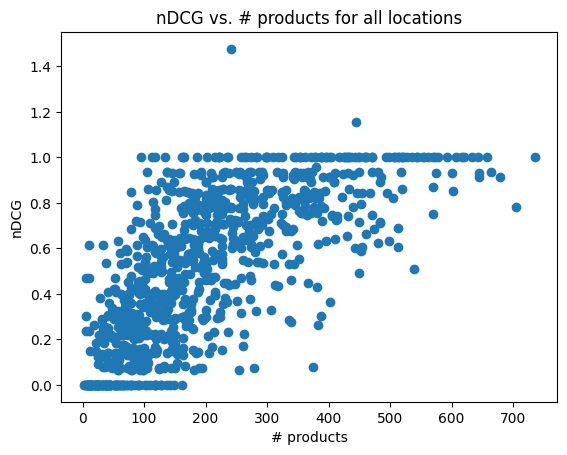

In [14]:
eval_loc_ndcg_hist = eval_with_ndcg_hist[["location_id", "ndcg"]]
eval_ndcg_hist_n_prods = eval_loc_ndcg_hist.join(pd.Series(n_prods_at_loc).to_frame("n_prods"), on = "location_id", how = "left")

eval_ndcg_hist_n_prods.plot(x = "n_prods", y = "ndcg", style = "o", legend = None)
plt.title("nDCG vs. # products for all locations")
plt.xlabel("# products")
plt.ylabel("nDCG")
plt.show()

### nDCG per location by number of products histogram

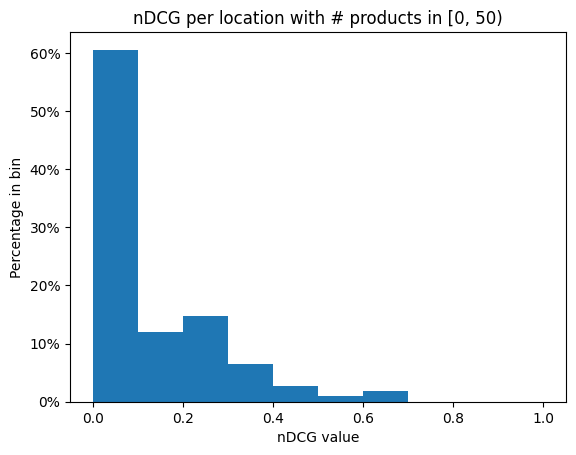

Average nDCG for locations with # products in [0, 50): 0.1080291687309618


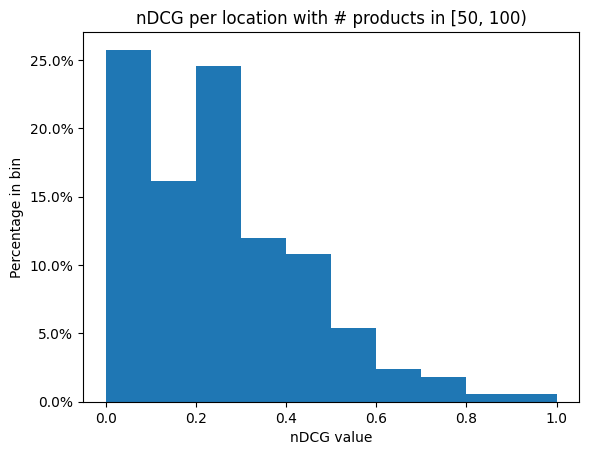

Average nDCG for locations with # products in [50, 100): 0.24734818674129455


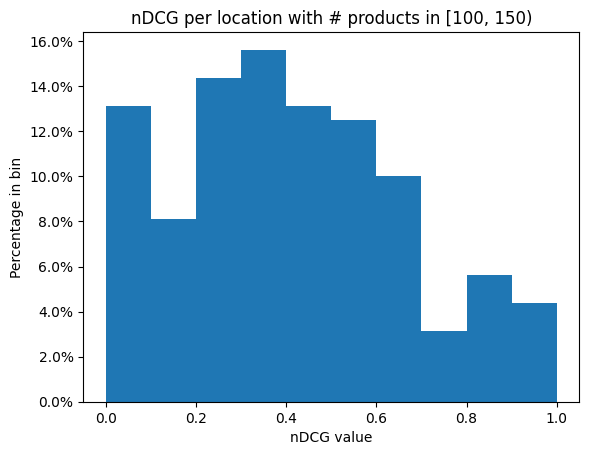

Average nDCG for locations with # products in [100, 150): 0.40968419986993626


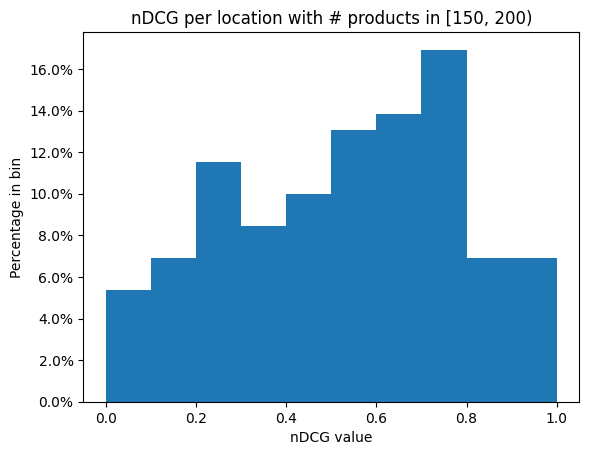

Average nDCG for locations with # products in [150, 200): 0.5328039674478466


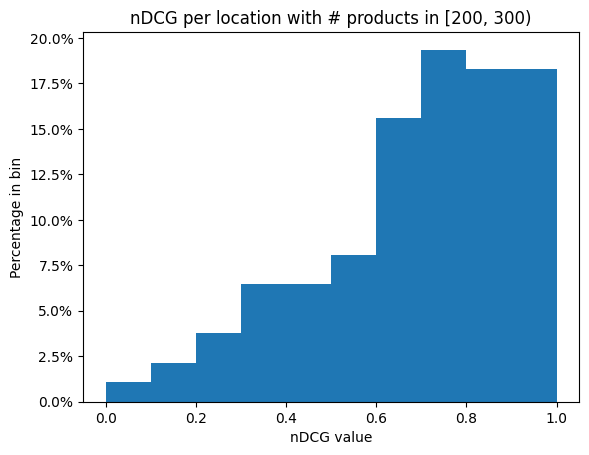

Average nDCG for locations with # products in [200, 300): 0.6942059971606767


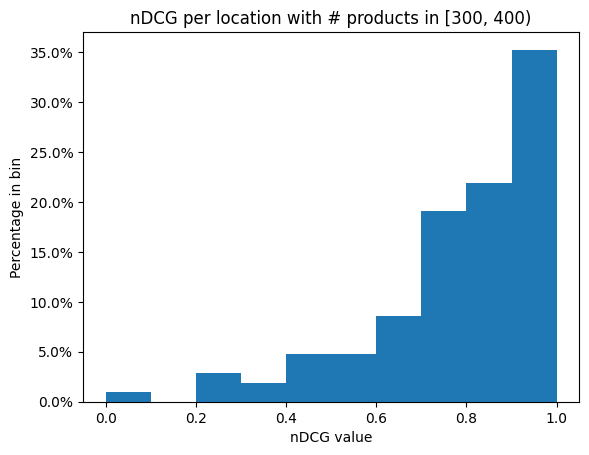

Average nDCG for locations with # products in [300, 400): 0.7846344160101847


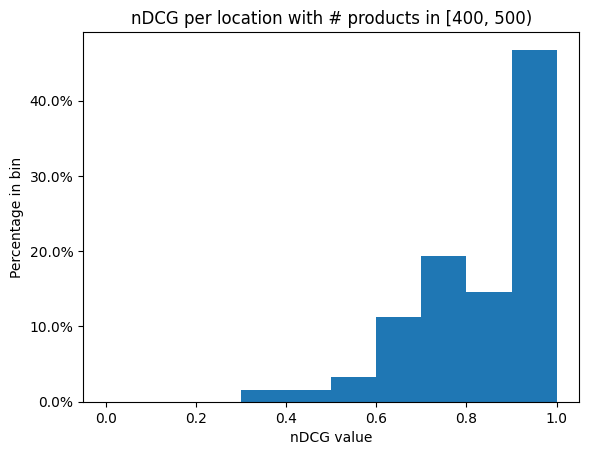

Average nDCG for locations with # products in [400, 500): 0.8480433339699098


In [15]:
min_n_prods_range = (0, 50, 100, 150, 200, 300, 400)
max_n_prods_range = (50, 100, 150, 200, 300, 400, 500)
count_not_percentage = False

for (min_n_prods, max_n_prods) in zip(min_n_prods_range, max_n_prods_range):
    eval_ndcg_hist_bounded_n_prods = eval_ndcg_hist_n_prods[(eval_ndcg_hist_n_prods["n_prods"] >= min_n_prods) & (eval_ndcg_hist_n_prods["n_prods"] < max_n_prods)]
    eval_ndcg_hist_bounded_n_prods_ndcg_only = eval_ndcg_hist_bounded_n_prods["ndcg"]

    if count_not_percentage:
        plt.hist(eval_ndcg_hist_bounded_n_prods_ndcg_only, bins = np.linspace(0, 1, 11))
        plt.ylabel("Frequency")
    else:
        plt.hist(eval_ndcg_hist_bounded_n_prods_ndcg_only, bins = np.linspace(0, 1, 11),\
            weights = np.ones(len(eval_ndcg_hist_bounded_n_prods_ndcg_only)) / len(eval_ndcg_hist_bounded_n_prods_ndcg_only))
        plt.ylabel("Percentage in bin")
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.title("nDCG per location with # products in [" + str(min_n_prods) + ", " + str(max_n_prods) + ")")
    plt.xlabel("nDCG value")
    plt.show()
    print("Average nDCG for locations with # products in [" + str(min_n_prods) + ", " + str(max_n_prods) + "): " + str(eval_ndcg_hist_bounded_n_prods_ndcg_only.mean()))

## 6 Train, Predict, and Evaluate on Whole Dataset

Earlier, we had split train (for model training) and test (for evaluation). In implementation, we have train = whole dataset, and we can evaluate on test = whole dataset.

In [16]:
## Data
data_set = cornac.data.Dataset.from_uir(data.itertuples(index=False), seed=SEED)
print('Number of users: {}'.format(data_set.num_users))
print('Number of items: {}'.format(data_set.num_items))

## Train
bpr_whole = cornac.models.BPR(
    k=NUM_FACTORS,
    max_iter=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    lambda_reg=LAMBDA_REG,
    verbose=True,
    seed=SEED
)
with Timer() as t:
    bpr_whole.fit(data_set)
print("Took {} seconds for training.".format(t))

## Predict
with Timer() as t:
    all_predictions_whole = predict_ranking(bpr, data, usercol='location_id', itemcol='product', remove_seen=False)
print("Took {} seconds for prediction.".format(t))

## Evaluate
eval_map_whole = map_at_k(data, all_predictions_whole, col_user='location_id', col_item='product', col_rating='sl_sold', col_prediction='prediction', k=TOP_K_WHOLE)
eval_ndcg_whole = ndcg_at_k(data, all_predictions_whole, col_user='location_id', col_item='product', col_rating='sl_sold', col_prediction='prediction', k=TOP_K_WHOLE)
eval_precision_whole = precision_at_k(data, all_predictions_whole, col_user='location_id', col_item='product', col_rating='sl_sold', col_prediction='prediction', k=TOP_K_WHOLE)
eval_recall_whole = recall_at_k(data, all_predictions_whole, col_user='location_id', col_item='product', col_rating='sl_sold', col_prediction='prediction', k=TOP_K_WHOLE)

print()
print("MAP:\t%f" % eval_map_whole,
      "NDCG:\t%f" % eval_ndcg_whole,
      "Precision@K:\t%f" % eval_precision_whole,
      "Recall@K:\t%f" % eval_recall_whole, sep='\n')

## Save recommendations
top_k_predictions_whole = get_top_k_items(all_predictions_whole, col_user='location_id', col_rating='prediction', k=TOP_K_WHOLE)
top_k_predictions_whole.drop("prediction", axis = 1, inplace = True)
# add column of true sales and rank of predicted products
top_all_true = get_top_k_items(data, col_user='location_id', col_rating='sl_sold', k=data_set.num_items)
top_k_predictions_whole = top_k_predictions_whole.merge(top_all_true, how = 'left', on = ['location_id', 'product'], suffixes = (None, "_true"))
top_k_predictions_whole["rank_true"] = top_k_predictions_whole["rank_true"].convert_dtypes()
top_k_predictions_whole.rename(columns = {"product": "predicted product", "sl_sold": "predicted product's true sales", "rank_true": "predicted product's true rank"}, inplace = True)
# add columns of true top-ranked products
top_all_true.rename(columns = {"product": "true product", "sl_sold": "true product's sales"}, inplace = True)
top_k_predictions_whole = top_k_predictions_whole.merge(top_all_true, how = 'left', on = ['location_id', 'rank'])
# reorder columns
top_k_predictions_whole = top_k_predictions_whole[["location_id", "rank", "true product", "true product's sales", "predicted product", "predicted product's true sales", "predicted product's true rank"]]
top_k_predictions_whole.to_csv(THIS_ENGINE_NAME + "_" + COUNTRY + "_top_" + str(TOP_K_WHOLE) + "_prod_recs.csv")

/Users/DanielShen/opt/anaconda3/envs/microsoft_rec/lib/python3.8/site-packages/cornac/data/dataset.py:361: UserWarning: 483 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


Number of users: 968
Number of items: 2062


100%|██████████| 100/100 [00:04<00:00, 22.56it/s, correct=96.82%, skipped=14.64%]


Optimization finished!
Took 4.4495 seconds for training.
Took 0.4095 seconds for prediction.

MAP:	0.281633
NDCG:	0.709790
Precision@K:	0.646484
Recall@K:	0.402739
